Found 899 images belonging to 6 classes.
Found 300 images belonging to 6 classes.
Found 900 images belonging to 6 classes.


Epoch 1/12
14/14 [==============================] - ETA: 0s - loss: 2.0877 - accuracy: 0.1964 
Epoch 1: val_accuracy improved from -inf to 0.19531, saving model to model.h5


C:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 488s 32s/step - loss: 2.0877 - accuracy: 0.1964 - val_loss: 1.9078 - val_accuracy: 0.1953 - lr: 1.0000e-05
Epoch 2/12
14/14 [==============================] - ETA: 0s - loss: 1.6418 - accuracy: 0.3617 
Epoch 2: val_accuracy did not improve from 0.19531
14/14 [==============================] - 488s 35s/step - loss: 1.6418 - accuracy: 0.3617 - val_loss: 1.8337 - val_accuracy: 0.1953 - lr: 1.0000e-05
Epoch 3/12
14/14 [==============================] - ETA: 0s - loss: 1.2828 - accuracy: 0.5102 
Epoch 3: val_accuracy did not improve from 0.19531
14/14 [==============================] - 535s 38s/step - loss: 1.2828 - accuracy: 0.5102 - val_loss: 1.7830 - val_accuracy: 0.1133 - lr: 1.0000e-05
Epoch 4/12
14/14 [==============================] - ETA: 0s - loss: 0.9563 - accuracy: 0.6850 
Epoch 4: val_accuracy did not improve from 0.19531
14/14 [==============================] - 538s 38s/step - loss: 0.9563 - accuracy: 0.6850 - val_loss: 1.7565 - val_accu

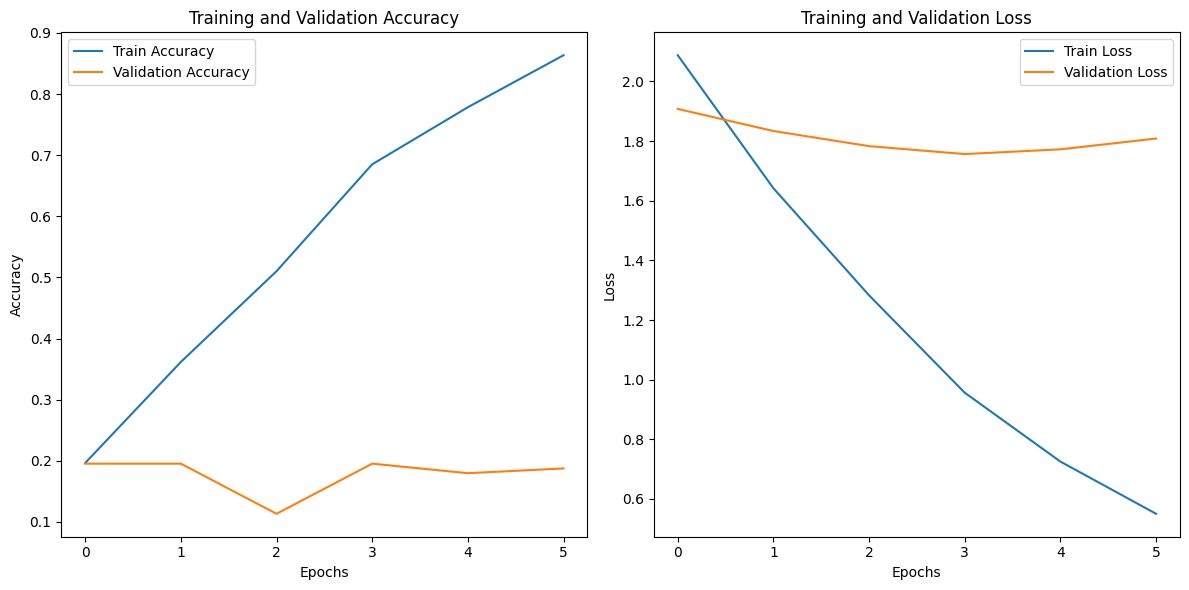

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 12
TRAIN_DATA_DIR = 'C:/Users/USER/Downloads/dataset/dataset/train'  # Update with your train data directory
VALIDATION_DATA_DIR = 'C:/Users/USER/Downloads/dataset/dataset/test'  # Update with your validation data directory
TEST_DATA_DIR = 'C:/Users/USER/Downloads/dataset/dataset/predict'  # Update with your test data directory

# Create data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Calculate class weights
class_counts = np.bincount(train_generator.classes)
total_samples = np.sum(class_counts)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}

# Validation and test data generators without data augmentation
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Create the ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False)

# Add custom classification head with dropout
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout layer
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='auto', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='auto', verbose=1)

def lr_scheduler(epoch):
    return 0.00001 * 0.5 ** (epoch // 10)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights,
    callbacks=[early_stopping, checkpoint, LearningRateScheduler(lr_scheduler)],
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# ... (the rest of your code for classification report and plotting remains the same)


# Define true labels and predictions for the test data
y_true = test_generator.classes
y_pred = model.predict(test_generator)

# Use argmax to get the predicted class indices
y_pred_indices = np.argmax(y_pred, axis=1)

# Get the class names for the target_names parameter
target_names = list(test_generator.class_indices.keys())

# Generate and print the classification report
# classification_rep = classification_report(y_true, y_pred_indices, target_names=target_names)
# print(classification_rep)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


1/1 [==============================] - 1s 1s/step


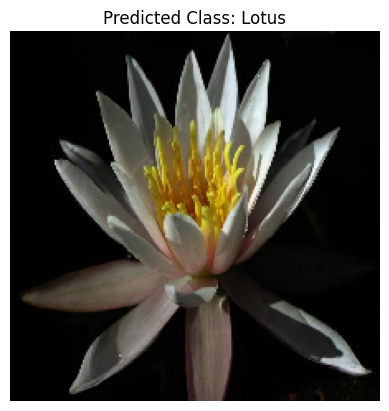

In [4]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('model.h5')  # Replace 'model.h5' with the path to your saved model file

# Define a dictionary that maps class indices to class labels
class_labels = {
    0: 'Rose', 
    1: 'Lotus',
    2: 'Olu',
    3: 'Anthurium',
    4: 'Temple flowers',
    5: 'Daisy',
}

# Define a function to predict and display the image
def predict_and_display_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions)
    predicted_class_label = class_labels[predicted_class_index]

    # Display the image
    plt.imshow(img[0])
    plt.axis('off')  # Hide axis
    plt.title(f"Predicted Class: {predicted_class_label}")
    plt.show()

# Example usage for predicting and displaying an image
img_path = 'C:/Users/USER/Downloads/dataset/dataset/test/Olu/image_00297.jpg'  # Replace with the path to your test image
predict_and_display_image(img_path)
